# Adversarial Examples on FAUST using Chebyshev Convolutions
First, we need to import the necessary modules.

In [5]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import sys
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The training and test data is loaded in memory using the `dataset` local module. 
To use the FAUST dataset, you need to download it from [here](http://faust.is.tue.mpg.de/) and place it in the directory `{repository-root}/datasets/faust/raw/`.



In [6]:
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')),".."))
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SRC_DIR = os.path.join(REPO_ROOT,"src")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/FAUST10.pt")

# repository modules
sys.path.insert(0, SRC_DIR)
import models
import train
import dataset
import utils

traindata = dataset.FaustDataset(FAUST, device=DEVICE, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, device=DEVICE, train=False, test=True,  transform_data=False)

C:\Users\giorg\Anaconda3\envs\adex\lib\site-packages\torch_geometric\data\dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `C:\Users\giorg\Adversarial-Examples-on-Meshes\datasets\faust\processed/processed` first.
  self.processed_dir))


Then we can define the classifier for the human pose classefication task; download the classifier parameters from [here](https://drive.google.com/drive/folders/1Bv0QM6R06nyCr9J-5sGIEtLKwxM6Qowa?usp=sharing). Move these parameters in `{repository-root}/model_data/FAUST10.pt` .



In [7]:
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE).to(DEVICE)
print(model)

ChebnetClassifier(
  (chebconv_0): ChebConv(3, 128, K=6, normalization=sym)
  (chebconv_1): ChebConv(128, 128, K=6, normalization=sym)
  (chebconv_2): ChebConv(128, 64, K=6, normalization=sym)
  (chebconv_3): ChebConv(64, 64, K=6, normalization=sym)
  (linear): Linear(in_features=6912, out_features=10, bias=True)
)


Training and evaluation can be done through the `train` local module.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.76it/s]

tensor(0.9500)


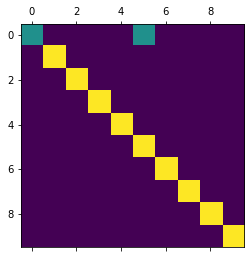

In [8]:
#train network
train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=0) # <- change here the number of epochs used for training

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model, epoch_number=1)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

### Searching for Targeted Adversarial Examples with C&W Approach
This part of the notebook shows how to search for adversarial examples using our version of the  *Carlini \& Wagner* approach.

In [ ]:
import adversarial.carlini_wagner as cw
from adversarial.carlini_wagner import CWBuilder, LowbandPerturbation, generate_adversarial_example

# get a random mesh from the dataset and a random target class
import random
while True:
    i = random.randint(0, len(testdata)-1)
    t = random.randint(0, testdata.num_classes-1)
    y = testdata[i].y.item()
    if y != t: break
mesh = testdata[i]

#parameters used to search the adversarial example
params = {
    CWBuilder.USETQDM:True,
    CWBuilder.MIN_IT:1000,      #<- number of iterations for the adversarial example computation (common value: 1000)
    CWBuilder.LEARN_RATE:1e-4, #<- learning rate used during optimization 
    CWBuilder.ADV_COEFF:1e-2, #<- starting coefficient applied to the adversarial loss (updated via exponential search)
    CWBuilder.REG_COEFF:1, #<- coefficient applied to the regularization term
    LowbandPerturbation.EIGS_NUMBER:40 #<- number of eigenvalues used for the low-band perturbation
    }  


# configure adversarial example components using builder
#--------------------------------------------------------
builder = CWBuilder(search_iterations=1)
builder.set_classifier(model)
builder.set_mesh(pos=mesh.pos, edges=mesh.edge_index.t(), faces=mesh.face.t())
builder.set_target(t)
builder.set_similarity_loss(cw.LocalEuclideanSimilarity)
builder.set_adversarial_loss(cw.AdversarialLoss)
builder.set_regularization_loss(cw.EmptyRegularizer) #<- i.e. no regularization term
adex = builder.build(**params)
print("adversarial attack: "+("successful" if adex.is_successful else "unsuccessful"))

We can finally see the actual adversarial example using **Plotly** (note: you need to install plotly before-hand)

In [ ]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()
    
def compare(pos1, faces1, pos2, faces2):
    n,m = pos1.shape[0], pos2.shape[0]
    tmpx = torch.cat([pos1, pos2],dim=0)
    tmpf = torch.cat([faces1, faces2+n], dim=0)
    color = torch.zeros([n+m],dtype=pos1.dtype, device=pos1.device)
    color[n:] = (pos1-pos2).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)
    
def show_logits(logits):
  logits = logits.cpu().detach().numpy().squeeze()
  m = min([logits.min()])
  num_classes = logits.shape[0]
  
  x_ticks = np.array(range(num_classes),dtype=float)
  ax = plt.subplot(111)
  ax.bar(x_ticks-0.2, logits-m, width=0.4, color='b', align='center')
  ax.legend(["logits"])
  plt.show()

visualization:

In [ ]:
visualize(adex.perturbed_pos, f, (adex.pos-adex.perturbed_pos).norm(p=2,dim=-1))
compare(adex.pos, adex.faces, adex.perturbed_pos, adex.faces)

## 2) Untargeted (FSGM and related methods)
Here instead is shown how to find adversarial examples using our iterative FSGM variant:

In [ ]:
from adversarial.pgd import PGDBuilder,LowBandTransform, ClipTransform, generate_adversarial_example
import random
i = random.randint(0, len(testdata)-1)
mesh = testdata[i]

params = {PGDBuilder.IT:10,  #<- number of iterations
         LowBandTransform.EIGS_NUMBER:40, #<- number of eigenvalues to use for the low-band filtering
         ClipTransform.EPSILON:1} #<- epsilon value (used for clipping pertrbation of vertices)

adex = generate_adversarial_example(
    mesh, model, alpha=0.002, **params, 
    clip_transform="pointwise", 
    lowband_transform="static", 
    gradient_transform="sign")

visualize(adex.perturbed_pos, f, (adex.pos -adex.perturbed_pos).norm(p=2,dim=-1))
print("adversarial attack: "+("successful" if adex.is_successful else "unsuccessful"))

# Adversarial Examples on SMAL
SMAL is handled in a similar fashion to FAUST. The pre-trained parameters can be found in the file `SMAL.pt` from [here](https://drive.google.com/drive/folders/1Bv0QM6R06nyCr9J-5sGIEtLKwxM6Qowa?usp=sharing). Move this file in `{repository-root}/model_data/SMAL.pt`.


In [ ]:
SMAL = os.path.join(REPO_ROOT,"datasets/smal")
SMAL_PARAMETERS = os.path.join(REPO_ROOT, "model_data/SMAL.pt")
traindata = dataset.SmalDataset(SMAL, device=DEVICE, train=True, test=False,transform_data=True)
testdata = dataset.SmalDataset(SMAL, device=DEVICE, train=False, test=True,transform_data=False)

model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=SMAL_PARAMETERS).to(DEVICE)

In [ ]:
#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model, epoch_number=1)
print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

the adversarial surfaces search is similar to FAUST:

In [ ]:
import adversarial.carlini_wagner as cw
from adversarial.carlini_wagner import CWBuilder, generate_adversarial_example

# get a random mesh from the dataset and a random target class
import random
while True:
    i = random.randint(0, len(testdata)-1)
    t = random.randint(0, testdata.num_classes-1)
    y = testdata[i].y.item()
    if y != t: break
mesh = testdata[i]

#parameters used to search the adversarial example
params = {
    CWBuilder.USETQDM:True,
    CWBuilder.MIN_IT:1000,      #<- number of iterations for the adversarial example computation (common value: 1000)
    CWBuilder.LEARN_RATE:1e-4, #<- learning rate used during optimization 
    CWBuilder.ADV_COEFF:1e-2, #<- starting coefficient applied to the adversarial loss (updated via exponential search)
    CWBuilder.REG_COEFF:1, #<- coefficient applied to the regularization term
    LowbandPerturbation.EIGS_NUMBER:40 #<- number of eigenvalues used for the low-band perturbation
    }  

# configure adversarial example using 'generate_adversarial_example'
#-------------------------------------------------------------------
adex = generate_adversarial_example(search_iterations=7, mesh=mesh, classifier=model, target=t, **params)